# Nonlinear Model Fitting
 
Nonlinear models typically do not have pleasant analytic posterior distributions. 

Here, we will demonstate three methods for parameter estimation in non-linear models: 

1. Grid search
2. Laplace approximation 
3. MCMC, Metropolis-Hastings

We will be working with the following nonlinear exponential model: 

$$ y = ae^{-bt} + \epsilon $$


### Generating Data







In [1]:
import numpy as np
true_a = 10
true_b = 2 
n = 50 
t = np.transpose(np.linspace(0,2,n))
sigma = 5

y = true_a * np.exp(-true_b*t) + sigma * np.random.randn(n)

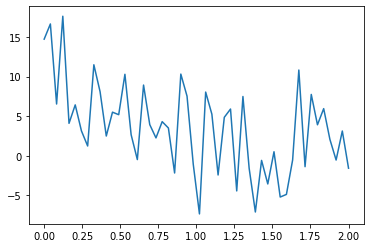

In [2]:
import matplotlib.pyplot as plt 
plt.plot(t, y)
plt.show()


### Grid Search

Let us assume that we we do not know $a$ and $b$ in the exponential model above. 

$$ y = ae^{-bx} + \epsilon \approx f(a,b) $$
 
We can define the likelihood function as the output $y$ given the function is parameterised with $a$ and $b$: 

$$ \mathcal{L} = p(y \mid a, b) = \mathcal{N}(y \mid f(a,b), \sigma^{2}) $$ 

To obtain a posterior distribution, we need to also define a prior on $a$ and $b$: 

$$ p(a,b) = \mathcal{N}(a \mid a_{0}, \sigma_{a,0}^{2}) \cdot \mathcal{N}(b \mid b_{0}, \sigma_{b,0}^{2}) $$

This gives as a posterior distribution: 

\begin{align}
 p(a,b \mid y) &\approx p(y \mid a, b) \cdot p(a, b)  \\
 \\
               &\approx  exp\bigg(-\frac{1}{2} \cdot \frac{(y - f(a,b))^{2}}{\sigma^{2}}\bigg)   \cdot p(a,b)  
\end{align}

To obtain the posterior using the grid method, we evalute pairs of $a$ and $b$ on a grid. We can then find the maximum value on the grid corresponding to the values of parameters $a$ and $b$. 




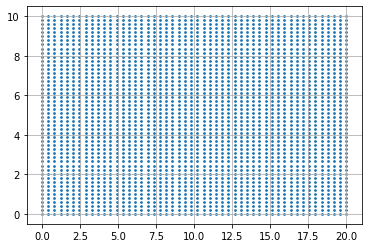

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

a = np.linspace(0,20,50)
b = np.linspace(0,10,50)

a_n, b_n = np.meshgrid(a, b)

plt.scatter(a_n,b_n, s= 3)
plt.grid(True)
plt.show()

The above figure shows the grid points where the posterior will be approximated. 

`a_n` is a (50,50) array with fixed intervals along the x dimension. 

`b_n` is a (50,50) array with fixed intervalsa along the y dimension.

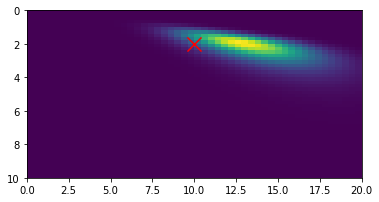

In [4]:
# define a lambda function to evaluate our function with parameters a and b without noise 
f = lambda a, b: a * np.exp(-b*t)

# define another lamnda function to evalute the normal probability density function  at given values of a and b
pdf = lambda a, b: np.exp(-(0.5/sigma**2) * np.sum((y - f(a,b).T)**2))

# set up a 2 dimensional array to fill values of a and b
likelihood_grid = np.ones([50,50])

# loop through values of a and b to populate the grid above, starting with a and working up the y (b) axis. 
for i, aa in enumerate(a):
    for j, bb in enumerate(b):
        likelihood_grid[i][j] = pdf(aa,bb) 

# normalise to the sum of the values (probability distributions should add to 1)
norm_likelihood_grid = likelihood_grid/np.sum(likelihood_grid)
 
# plot the norm_posterior with as a heatmap with the true values plotted as a large red cross
plt.imshow(norm_likelihood_grid.T, extent = [0,20,10,0])
plt.scatter(true_a,true_b, color='r', marker='x', s=200)
plt.show()

#### Altnerative python implementation

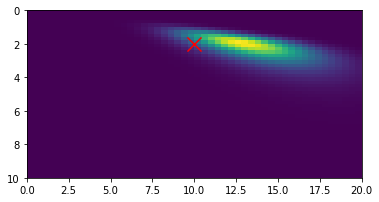

In [5]:
## flatten and reshape arrays to perform matrix algebra
aa = np.tile(a_n.flatten(),(50,1))
bb = b_n.flatten().reshape(2500,1)
tt = t.reshape(len(t),1)
yy = np.tile(y, (2500,1))

# calculate grid values of f(a,b) taking advantage of the shapes of aa, bb and tt
f_ab = aa * np.exp(-tt@bb.T)

# calculate likelihood from normal pdf
likelihood = np.exp(-(0.5/sigma**2) * np.sum((yy.T - f_ab)**2,0))

# normalise to the sum of the values (probability distributions should add to 1)
norm_likelihood = likelihood / np.sum(likelihood)

#reshape (since we vectories the grid) and plot
plt.imshow(norm_likelihood.reshape(50,50), extent = [0,20,10,0])
plt.scatter(true_a,true_b, color='r', marker='x', s=200)
plt.show()
